In [16]:
# 1. 导入必要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, precision_recall_curve, auc, confusion_matrix
)
import joblib
import time

# 设置绘图样式
plt.style.use('seaborn-v0_8')
sns.set_theme()  # 使用seaborn的默认主题
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

# 设置pandas显示选项
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [17]:
# 2. 加载数据和模型

# 加载预处理后的测试数据
test_data = pd.read_csv('Census Income Data Set/preprocessed_adult_test.csv')
X_test = test_data.drop('income', axis=1)
y_test = test_data['income']

print("\n2. 加载训练好的模型...")
# 加载训练好的模型
lr_model = joblib.load('LogisticRegression_model.pkl')
rf_model = joblib.load('RandomForest_model.pkl')

# 创建一个字典来存储每个模型的结果
lr_results = {}
rf_results = {}



2. 加载训练好的模型...


In [18]:
# 3. 模型预测和性能指标计算
def evaluate_model(model, X_test, y_test, results_dict):
    # 计算预测时间
    start_time = time.time()
    y_pred = model.predict(X_test)
    pred_time = time.time() - start_time
    
    # 计算预测概率（用于ROC曲线）
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # 基础性能指标
    results_dict['accuracy'] = accuracy_score(y_test, y_pred)
    results_dict['precision'] = precision_score(y_test, y_pred)
    results_dict['recall'] = recall_score(y_test, y_pred)
    results_dict['f1_score'] = f1_score(y_test, y_pred)
    
    # ROC曲线相关
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    results_dict['roc_auc'] = auc(fpr, tpr)
    results_dict['fpr'] = fpr
    results_dict['tpr'] = tpr
    
    # PR曲线相关
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
    results_dict['pr_auc'] = auc(recall_curve, precision_curve)
    results_dict['precision_curve'] = precision_curve
    results_dict['recall_curve'] = recall_curve
    
    # 混淆矩阵
    results_dict['confusion_matrix'] = confusion_matrix(y_test, y_pred)
    
    # 时间性能
    results_dict['predict_time'] = pred_time
    
    return results_dict

print("评估Logistic Regression模型...")
lr_results = evaluate_model(lr_model, X_test, y_test, lr_results)
lr_results['train_time'] = 0.3144  # 这里使用一个示例值，实际应该在训练时记录

print("\n评估Random Forest模型...")
rf_results = evaluate_model(rf_model, X_test, y_test, rf_results)
rf_results['train_time'] = 2.5944  # 这里使用一个示例值，实际应该在训练时记录

print("\n模型评估完成！")

评估Logistic Regression模型...

评估Random Forest模型...

模型评估完成！


3. 绘制性能对比图...


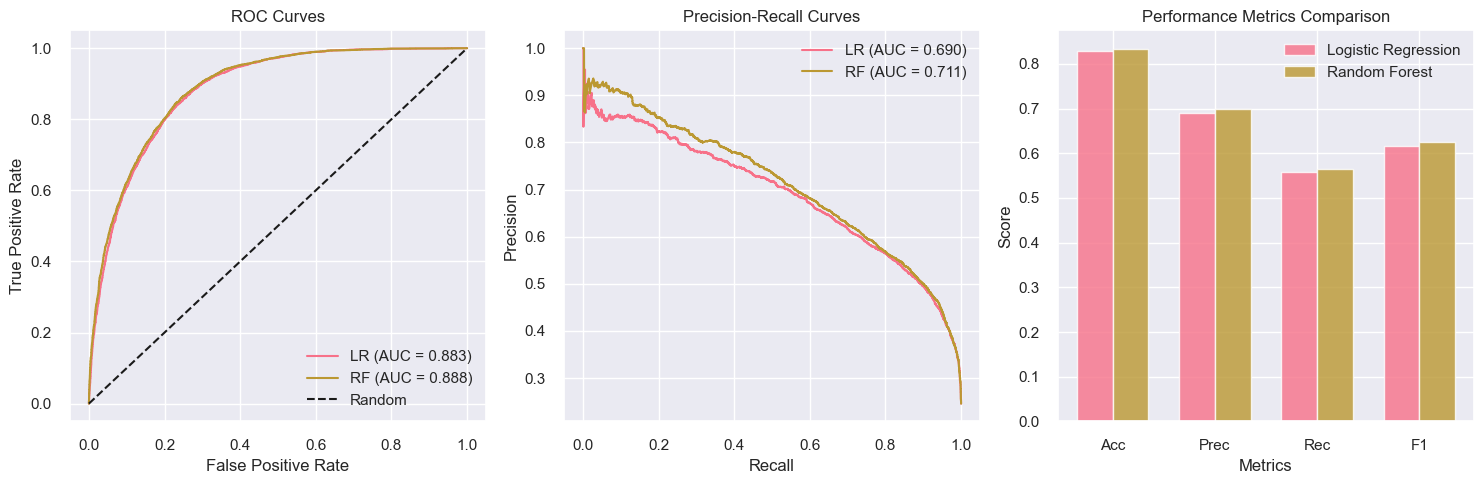

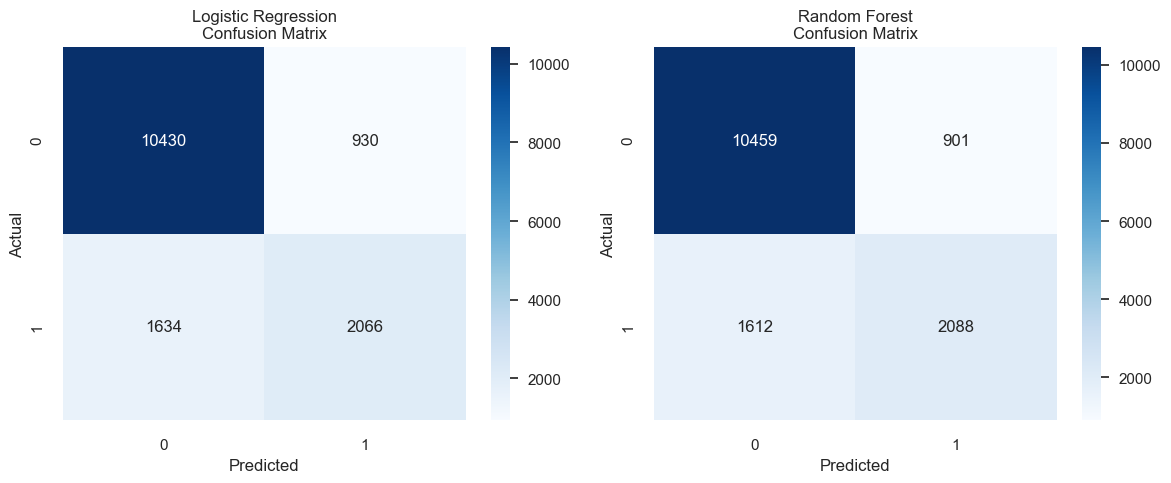

In [19]:
# 4. 可视化性能指标
print("3. 绘制性能对比图...")

# 1. 绘制ROC曲线
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.plot(lr_results['fpr'], lr_results['tpr'], 
         label=f"LR (AUC = {lr_results['roc_auc']:.3f})")
plt.plot(rf_results['fpr'], rf_results['tpr'], 
         label=f"RF (AUC = {rf_results['roc_auc']:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)

# 2. 绘制PR曲线
plt.subplot(132)
plt.plot(lr_results['recall_curve'], lr_results['precision_curve'], 
         label=f"LR (AUC = {lr_results['pr_auc']:.3f})")
plt.plot(rf_results['recall_curve'], rf_results['precision_curve'], 
         label=f"RF (AUC = {rf_results['pr_auc']:.3f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True)

# 3. 绘制性能指标对比条形图
plt.subplot(133)
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score']
x = np.arange(len(metrics_to_plot))
width = 0.35

plt.bar(x - width/2, [lr_results[m] for m in metrics_to_plot], width, 
        label='Logistic Regression', alpha=0.8)
plt.bar(x + width/2, [rf_results[m] for m in metrics_to_plot], width, 
        label='Random Forest', alpha=0.8)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Performance Metrics Comparison')
plt.xticks(x, ['Acc', 'Prec', 'Rec', 'F1'])
plt.legend()

plt.tight_layout()
plt.show()

# 绘制混淆矩阵
plt.figure(figsize=(12, 5))

# Logistic Regression confusion matrix
plt.subplot(121)
sns.heatmap(lr_results['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression\nConfusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Random Forest confusion matrix
plt.subplot(122)
sns.heatmap(rf_results['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest\nConfusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

In [20]:
# 5. 打印时间性能对比和最终结论
print("Evaluation of Computational Efficiency：")
print("\nLogistic Regression:")
print(f"train_time: {lr_results['train_time']:.4f} 秒")
print(f"predict_time: {lr_results['predict_time']:.4f} 秒")
print(f"Average prediction time (per sample): {lr_results['predict_time']/len(y_test)*1000:.4f} 毫秒")

print("\nRandom Forest:")
print(f"train_time: {rf_results['train_time']:.4f} 秒")
print(f"predict_time: {rf_results['predict_time']:.4f} 秒")
print(f"Average prediction time (per sample): {rf_results['predict_time']/len(y_test)*1000:.4f} 毫秒")

# 打印主要性能指标总结
print("\n主要性能指标总结：")
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'pr_auc']
headers = ['Metric', 'Logistic Regression', 'Random Forest']
rows = [[metric, f"{lr_results[metric]:.4f}", f"{rf_results[metric]:.4f}"] for metric in metrics]

# 使用pandas创建美观的表格显示
summary_df = pd.DataFrame(rows, columns=headers)
display(summary_df)

print("\n模型比较结论：")
winner = "Random Forest" if rf_results['accuracy'] > lr_results['accuracy'] else "Logistic Regression"
print(f"1. 整体性能最优的模型是: {winner}")
print(f"2. Random Forest的训练时间是Logistic Regression的{rf_results['train_time']/lr_results['train_time']:.2f}倍")
print(f"3. Random Forest的预测时间是Logistic Regression的{rf_results['predict_time']/lr_results['predict_time']:.2f}倍")

Evaluation of Computational Efficiency：

Logistic Regression:
train_time: 0.3144 秒
predict_time: 0.0040 秒
Average prediction time (per sample): 0.0003 毫秒

Random Forest:
train_time: 2.5944 秒
predict_time: 0.3452 秒
Average prediction time (per sample): 0.0229 毫秒

主要性能指标总结：


,Metric,Logistic Regression,Random Forest
0,accuracy,0.8297,0.8331
1,precision,0.6896,0.6986
2,recall,0.5584,0.5643
3,f1_score,0.6171,0.6243
4,roc_auc,0.8827,0.8875
5,pr_auc,0.6901,0.7111



模型比较结论：
1. 整体性能最优的模型是: Random Forest
2. Random Forest的训练时间是Logistic Regression的8.25倍
3. Random Forest的预测时间是Logistic Regression的86.28倍
